In [ ]:
UNIQUENAME = 'alnewma'

In [ ]:
from __future__ import division 

This notebook is used for SI 650 Information Retrieval class. You should implement retrieval functions and report corresponding results in your submission on Canvas. 


In [7]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)


In [8]:
# install metapy, it may take several minutes.
!pip install metapy
import metapy

In [9]:
# Reading Data
!wget -nc https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt
!wget -N https://meta-toolkit.org/data/2016-11-10/cranfield.tar.gz
!tar xf cranfield.tar.gz

File ‘lemur-stopwords.txt’ already there; not retrieving.

--2018-10-11 18:02:18--  https://meta-toolkit.org/data/2016-11-10/cranfield.tar.gz
Resolving meta-toolkit.org (meta-toolkit.org)... 50.116.41.177, 2600:3c02::f03c:91ff:feae:b777
Connecting to meta-toolkit.org (meta-toolkit.org)|50.116.41.177|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘cranfield.tar.gz’ not modified on server. Omitting download.



In [ ]:
# Setting dataset
with open('cranfield/tutorial.toml', 'w') as f:
    f.write('type = "line-corpus"\n')
    f.write('store-full-text = true\n')

config = """prefix = "." # tells MeTA where to search for datasets

dataset = "cranfield" # a subfolder under the prefix directory
corpus = "tutorial.toml" # a configuration file for the corpus specifying its format & additional args

index = "cranfield-idx" # subfolder of the current working directory to place index files

query-judgements = "cranfield/cranfield-qrels.txt" # file containing the relevance judgments for this dataset

stop-words = "lemur-stopwords.txt"

[[analyzers]]
method = "ngram-word"
ngram = 1
filter = "default-unigram-chain"
"""
with open('cranfield-config.toml', 'w') as f:
    f.write(config)

# **1. Build Retrieval Function**

In [ ]:
# Make sure you have installed metapy package and downloaded the data before running the following code

In [ ]:
# Build the index for dataset.
inv_idx = metapy.index.make_inverted_index('cranfield-config.toml')

In [ ]:
# inv_idx.doc_freq?print(inv_idx)

In [ ]:
# Creating own ranking function
class SimpleRanker(metapy.index.RankingFunction):                                            
                          
    # https://meta-toolkit.org/doxygen/structmeta_1_1index_1_1score__data.html 
    
    def __init__(self, some_param=1.0):                                             
        # adding parameter that we want the ranker to have, so we need to add it before invoking the super class
        self.param = some_param
        # calling the initializer on the ranking function class (the super class)
        super(SimpleRanker, self).__init__()                                        
    
    # where sd=score data object
    # score_one = scoring for one term/word
    def score_one(self, sd):
        # sd.doc_term_count = num times a term appears in the current doc
        # sd.doc_unique_terms = num unique terms in the doc
        # sd.doc_size=size of the current document
        return (self.param + sd.doc_term_count) / (self.param * sd.doc_unique_terms + sd.doc_size)

**Add your answer in the cells below:**

In [ ]:
import math
import numpy as np

class Pivoted(metapy.index.RankingFunction):                                                                                                                    
    def __init__(self, s = 0.1):                                             
        self.s = s
        # You *must* invoke the base class __init__() here!
        super(Pivoted, self).__init__()                                        
                                                                                 
    def score_one(self, sd):
        """
        You need to override this function to return a score for a single term.
        
        You may want to call some of the following variables when implementing your retrieval function:
        
        sd.avg_dl: average document length of the collection
        sd.num_docs: total number of documents in the index
        sd.total_terms: total number of terms in the index
        sd.query_length: the total length of the current query (sum of all term weights)
        sd.query_term_weight: query term count (or weight in case of feedback)
        sd.doc_count: number of documents that a term t_id appears in
        sd.corpus_term_count: number of times a term t_id appears in the collection
        sd.doc_term_count: number of times the term appears in the current document
        sd.doc_size: total number of terms in the current document
        sd.doc_unique_terms: number of unique terms in the current document
        
        """
         
        s = self.s 
        factor_one = np.log((sd.num_docs +1)/(sd.doc_count))
        factor_two_numerator = (1+ np.log(1+np.log(sd.doc_term_count))) 
        factor_two_denominator = (1-s + s*(sd.doc_size/sd.avg_dl))
        factor_three = sd.query_term_weight
        
        
        #Fill your answers here

        return factor_one * (factor_two_numerator/factor_two_denominator) * factor_three

In [ ]:
import math
class BM25(metapy.index.RankingFunction):                                            
    """                                                                          
    Create a new ranking function in Python that can be used in MeTA.             
    """                                                                          
    def __init__(self, k1 = 1.2, b = 0.75, k3 = 500):                                             
        self.k1 = k1
        self.b = b
        self.k3 = k3
        # You *must* invoke the base class __init__() here!
        super(BM25, self).__init__()                                        
                                                                                 
    def score_one(self, sd):
        """
        You need to override this function to return a score for a single term.
        
        You may want to call some of the following variables when implementing your retrieval function:
        
        sd.avg_dl: average document length of the collection
        sd.num_docs: total number of documents in the index
        sd.total_terms: total number of terms in the index
        sd.query_length: the total length of the current query (sum of all term weights)
        sd.query_term_weight: query term count (or weight in case of feedback)
        sd.doc_count: number of documents that a term t_id appears in
        sd.corpus_term_count: number of times a term t_id appears in the collection
        sd.doc_term_count: number of times the term appears in the current document
        sd.doc_size: total number of terms in the current document
        sd.doc_unique_terms: number of unique terms in the current document
        
        """
        k1 = self.k1
        b = self.b
        k3 = self.k3
        
        factor_one_numerator = sd.num_docs - sd.doc_count + 0.5
        factor_one_denominator = sd.doc_count + 0.5
        factor_one = np.log(factor_one_numerator/factor_one_denominator)
        
        factor_two_numerator = (k1 + 1) * sd.doc_term_count
        factor_two_denominator = (k1 * (1 - b + b *(sd.doc_size/sd.avg_dl))) + sd.doc_term_count
        factor_two = factor_two_numerator/factor_two_denominator
        
        factor_three_numerator = (k3 + 1) * sd.query_term_weight
        factor_three_denominator = (k3 + sd.query_term_weight)
        factor_three = factor_three_numerator/factor_three_denominator
        
        #Fill your answer here
        return factor_one * factor_two * factor_three

In [ ]:
# We currently use the simple ranker here. Please change it to Pivoted Ranker after you implement it.

# Change k1, k3, b, and s values within the function calls below: e.g. Pivoted(k1 = 3) <-- look into number ranges
ranker = SimpleRanker()
# ranker = Pivoted()   
#ranker = BM25() 

# **2 Evaluate Retrieval Function**

In [ ]:
ev = metapy.index.IREval('cranfield-config.toml')

In [ ]:
# 9 parameter values for the Normalization and BM25 functions:
range_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [20]:
# Evaluate top 30 search results for cranfield dataset
def visualizations(p, lst):
  ranker = Pivoted(p)
  num_results = 30

  precision_list = []
  with open('cranfield/cranfield-queries.txt') as query_file:
      for query_num, line in enumerate(query_file):
          query = metapy.index.Document()
          query.content(line.strip())
          results = ranker.score(inv_idx, query, num_results)                            
          avg_p = ev.avg_p(results, query_num + 1, num_results)
          precision_list.append(ev.precision(results,query_num+1,num_results))
          
  # Print Ranking Performance
  print ("MAP:", ev.map())
  lst.append(ev.map())
#   print ("Precison@30",sum(precision_list) / len(precision_list))
  return

# loop through list of parameters in Pivoted function
map_results = [] # for each of the s values in range_lst
for elem in range_lst:
  visualizations(elem, map_results)


MAP: 0.2700253959532719
MAP: 0.272310425752299
MAP: 0.27477831490269583
MAP: 0.2748158649449918
MAP: 0.27437286425664936
MAP: 0.2725080949818613
MAP: 0.2699139019538289
MAP: 0.2659148869707835
MAP: 0.26082835340925714


In [ ]:
# Plot the performance curve - use seaborn
# Report the best performance of my function

In [ ]:
# Print Ranking Performance
# print ("MAP:", ev.map())
# print ("Precison@30",sum(precision_list) / len(precision_list))

In [ ]:
# Initial Results for each function

# Simple Ranker output
# MAP: 0.19017510256207787
# Precison@30 0.09866666666666667

# Pivoted Normalization output - did not change s value
# MAP: 0.2700253959532719
# Precison@30 0.11792592592592595

# BM25 output - did not change k1, k3, or b values
# MAP: 0.28023656742202474
# Precison@30 0.12148148148148157

In [24]:
# Evaluate top 30 search results for cranfield dataset
def BMvisualizations(p, lst):
  ranker = BM25(b=p)
  num_results = 30

  precision_list = []
  with open('cranfield/cranfield-queries.txt') as query_file:
      for query_num, line in enumerate(query_file):
          query = metapy.index.Document()
          query.content(line.strip())
          results = ranker.score(inv_idx, query, num_results)                            
          avg_p = ev.avg_p(results, query_num + 1, num_results)
          precision_list.append(ev.precision(results,query_num+1,num_results))
          
  # Print Ranking Performance
  print ("MAP:", ev.map())
  lst.append(ev.map())
#   print ("Precison@30",sum(precision_list) / len(precision_list))
  return

# loop through list of parameters in Pivoted function
bm_map_results = [] # for each of the s values in range_lst
for elem in range_lst:
  BMvisualizations(elem, bm_map_results)

MAP: 0.2608946941418466
MAP: 0.261358397435433
MAP: 0.2621237579572338
MAP: 0.26284582081969454
MAP: 0.2637742731713137
MAP: 0.26469802686432364
MAP: 0.2656134511105819
MAP: 0.2664990444450756
MAP: 0.267300725124484


**Add your answer in the cells below:**


In [ ]:
# Evaluate different settings for Pivoted and BM25.


Please draw plots to report the results of parameter tuning for Pivoted and BM25.

In [ ]:
# !pip install seaborn==0.9.0
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


In [26]:
print (sns.__version__)

0.9.0


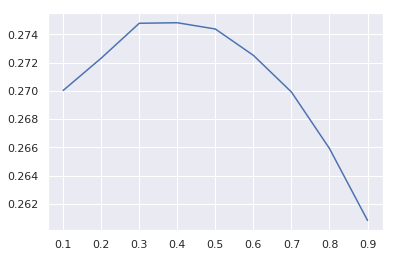

In [27]:
# Plot everything useing seaborn
# Plot Pivoted results, x-axis=parameters, y-axis=MAP

ax = sns.lineplot(x=range_lst, y=map_results)
ax
# range_lst
# map_results

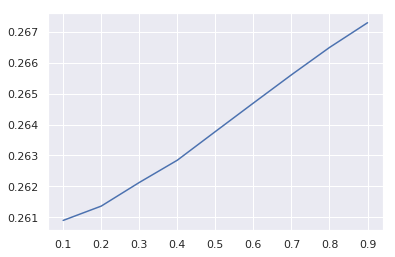

In [30]:
# Plot everything useing seaborn
# Plot BM25 results, x-axis=parameters, y-axis=MAP
ax = sns.lineplot(x=range_lst, y=bm_map_results)
ax

# range_lst
# bm_map_results

#**Findings**

The best performance for the Pivoted function was where the parameter was 0.4, giving a value of 0.2748. 

The best performance for the BM25 function was at parameter value 0.9, giving a MAP value of 0.267.

# Testing Search Results for a Single Query

In [ ]:
query = metapy.index.Document()
query.content("fluid")
top_docs = ranker.score(inv_idx, query, num_results=5)

In [33]:
for num, (d_id, _) in enumerate(top_docs):
    content = inv_idx.metadata(d_id).get('content')
    print("{}. {}...\n".format(num + 1, content))

1. energy equation approximations in fluid mechanics . discussion of several forms of the energy equation and of their use for the study of the flow of nearly incompressible fluids ....

2. simple shear flow past a flat plate in a compressible viscous fluid . by transformation of variables, the problem of a simple shear flow of a compressible fluid over a flat plate is reduced to the corresponding problem for an incompressible fluid .  the prandtl number of the compressible fluid is assumed to be unity and its viscosity to be a linear function of temperature ....

3. laminar jet mixing of two compressible fluids with heat release . the laminar jet mixing problems with heat release have been formulated . a general discussion of the solution of these problems is also given . the important parameters of these problems are brought out .  some specific cases of the jet mixing problem, such as jet mixing of one compressible fluid, isothermal jet mixing of two compressible fluids, and isovel 

**Please submit your code for Pivoted and BM25 class to canvas. We need your code to verify your results.**